<a href="https://colab.research.google.com/github/MaggieJian/Final-AI-Coursework/blob/main/Rollout_of_each_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Roll-out on a Full Image
### Introduction
Applying machine learning models to entire, full-sized images—especially in the realm of image processing—presents a distinct set of challenges and opportunities. Such a "roll-out" doesn't just involve stretching a model's capabilities across larger pixel dimensions; it tests the model's capacity to consistently and correctly generate outputs, be it segmentation or classification maps, across varying regions of an image.

### Preparation
- Here, we need to process the image to be rolled-out into the shape that is compatible to our model input shape. For example, the model input shape is `(3, 3, 21)`. The below code is for processing the data.


In [ ]:
# Mount your drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Install dependencies

In [ ]:
pip install netCDF4

In [ ]:
import netCDF4
import pyproj
import matplotlib.pyplot as plt
from math import pi
from sklearn.feature_extraction import image
import numpy as np

# Function to convert coordinates from WGS84 to EASE-Grid 2.0 projection
def WGS84toEASE2(lon, lat):
    # Initialise the EASE-Grid 2.0 projection
    proj_EASE2 = pyproj.Proj("+proj=laea +lon_0=0 +lat_0=90 +x_0=0 +y_0=0 +ellps=WGS84 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs")
    # Initialise the WGS84 projection
    proj_WGS84 = pyproj.Proj("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")
    # Transform the coordinates from WGS84 to EASE-Grid 2.0
    x, y = pyproj.transform(proj_WGS84, proj_EASE2, lon, lat)
    return x, y

# Directory setup for data files
directory = '/content/drive/MyDrive/Week 3/S3A_OL_1_EFR____20180307T054004_20180307T054119_20180308T091959_0075_028_319_1620_LN1_O_NT_002.SEN3'

# Load in geolocation data from a NetCDF file
geolocation = netCDF4.Dataset(directory+'/geo_coordinates.nc')
lat = geolocation.variables['latitude'][:]
lon = geolocation.variables['longitude'][:]

# Load in radiance data for a specific band (Band Oa01) from a NetCDF file
Band_Oa01 = netCDF4.Dataset(directory+'/Oa01_radiance.nc')
Oa01_Radiance = Band_Oa01.variables['Oa01_radiance'][:]

# Convert the longitude and latitude to EASE-Grid 2.0 coordinates
X, Y = WGS84toEASE2(lon, lat)

# Load in additional instrument data from a NetCDF file
OLCI_file_p = directory
instrument_data = netCDF4.Dataset(OLCI_file_p+'/instrument_data.nc')
solar_flux = instrument_data.variables['solar_flux'][:]
solar_flux_Band_Oa01 = solar_flux[0]  # Solar flux for Band Oa01
detector_index = instrument_data.variables['detector_index'][:]

# Load in tie geometries (e.g., Solar Zenith Angle) from a NetCDF file
tie_geometries = netCDF4.Dataset(OLCI_file_p+'/tie_geometries.nc')
SZA = tie_geometries.variables['SZA'][:]

# Initialise lists to store bands and patches
Bands = []
Patches = []

# Calculate the number of patches (nx, ny)
nx = X.shape[0] - 2
ny = X.shape[1] - 2
q = 0

# Process each band
for i in [2, 5, 7, 16]:  # Loop through 21 bands
    solar_flux_Band_Oa01 = solar_flux[q]
    print(i)
    bandnumber = '%02d' % (i)
    Band_Oa_temp = netCDF4.Dataset(directory+'/Oa'+bandnumber+'_radiance.nc')

    width = instrument_data.dimensions['columns'].size
    height = instrument_data.dimensions['rows'].size

    # Calculate the Top of Atmosphere Bidirectional Reflectance Factor (TOA BRF)
    TOA_BRF = np.zeros((height, width), dtype='float32')
    angle = np.zeros((TOA_BRF.shape[0], TOA_BRF.shape[1]))
    for x in range(TOA_BRF.shape[1]):
        angle[:, x] = SZA[:, int(x / 64)]

    oa = Band_Oa_temp.variables['Oa' + bandnumber + '_radiance'][:]
    TOA_BRF = np.zeros((height, width), dtype=float)
    TOA_BRF = np.pi * np.asarray(oa) / solar_flux_Band_Oa01[detector_index] / np.cos(np.radians(angle))

    Bands.append(TOA_BRF)
    # Extract patches of size 3x3 from the TOA BRF and reshape for further processing
    Patches.append(image.extract_patches_2d(np.array(TOA_BRF), (3, 3)).reshape(nx, ny, 3, 3))
    q += 1

# Convert the list of patches to a NumPy array and reshape for machine learning model input
Patches_array = np.asarray(Patches)
x_test_all = np.moveaxis(Patches_array, 0, -1).reshape(Patches_array.shape[1] * Patches_array.shape[2], 3, 3, 4)


<ipython-input-3-ac116d8332a4>:15: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2, lon, lat)


2
5
7
16


### Model Application
In this phase, the trained model processes the entire image, generating outputs that classify the different regions into respective categories such as sea-ice and leads. Let's say your saved model is called `model`.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
model = tf.keras.models.load_model('/content/drive/MyDrive/Week_2/Model_ViT/')

In [ ]:
! ls /content/drive/MyDrive/Week_2/Model_RF/

assets	fingerprint.pb	keras_metadata.pb  saved_model.pb  variables


In [ ]:
# Make predictions on the full image
y_pred=model.predict(x_test_all, batch_size = 250)
y_pred1 = np.argmax(y_pred,axis = 1)
# Reshape it for display
map1=y_pred1.reshape(Patches_array.shape[1], Patches_array.shape[2])

33341/33341 [==============================] - 92s 3ms/step


In [ ]:
np.save('/content/drive/MyDrive/Week 3/Week3_Rollout/ViT_rollout', map1)

(array([6944500.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0., 1390682.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

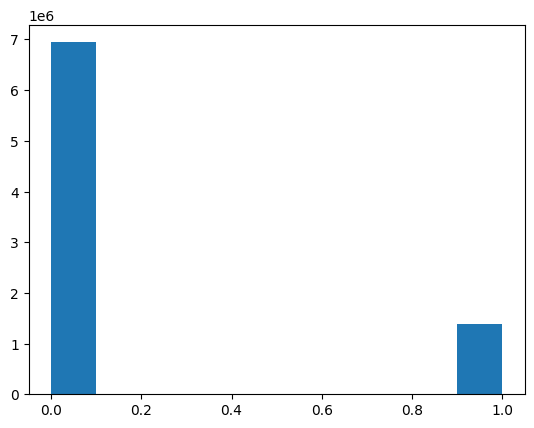

In [ ]:
plt.hist(map1.ravel())

### Display Results
Visual inspection plays a crucial role here. By juxtaposing the model-generated classified images against the original, we can discern the model's aptitude in retaining the intrinsic spatial structures and patterns of the original image.


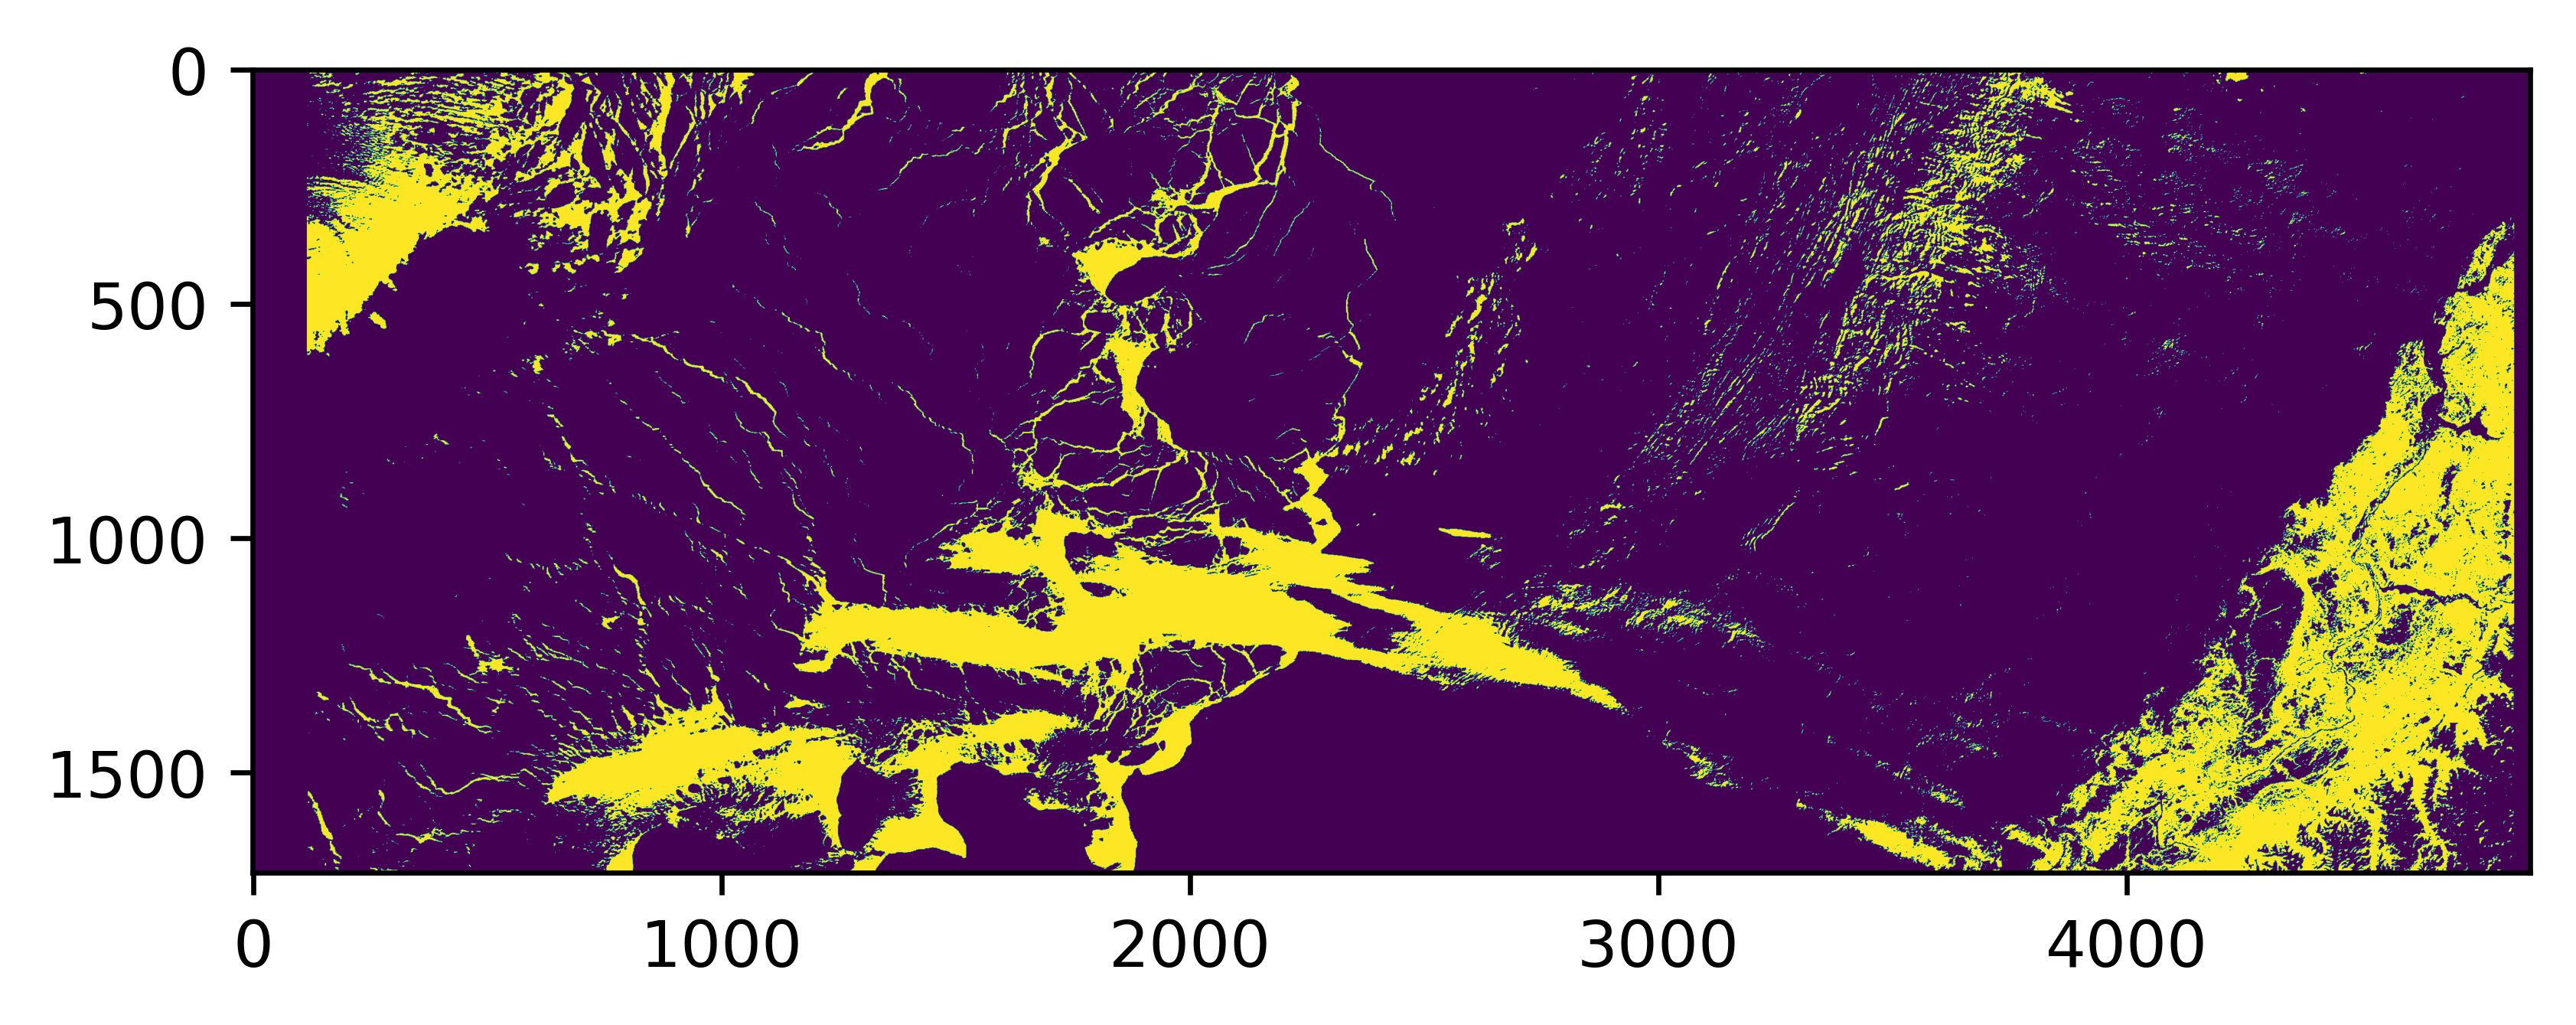

In [ ]:
# Alter the view setting
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 600
# Show the map
plt.imshow(map1)

In [ ]:
# Try saving the CNN image

np.save()

import matplotlib.pyplot as plt

plt.savefig(os.path.join(/content/drive/MyDrive/Week 3, 'MyCNNRolloutRawImage', map1))

SyntaxError: invalid syntax (<ipython-input-16-4fbf9edad964>, line 5)

  Below is a full code of roll-out in a loop manner. A list of filenames of the files that contain the OLCI netCDF files is needed. The below code is a loop that go through each OLCI image that you want to roll-out. You can edit the list of filenames as required.

In [ ]:
import pyproj
import matplotlib.pyplot as plt
from math import pi

# Function to convert coordinates from WGS84 to EASE-Grid 2.0 projection
def WGS84toEASE2(lon, lat):
    # Initialise the EASE-Grid 2.0 projection (Lambert Azimuthal Equal Area projection)
    proj_EASE2 = pyproj.Proj("+proj=laea +lon_0=0 +lat_0=90 +x_0=0 +y_0=0 +ellps=WGS84 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs")
    # Initialise the WGS84 projection
    proj_WGS84 = pyproj.Proj("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")
    # Transform the coordinates from WGS84 to EASE-Grid 2.0
    x, y = pyproj.transform(proj_WGS84, proj_EASE2, lon, lat)
    return x, y

# Directory setup for data files
directory = folder_name
directory = '/lustre/home/zcakwc1/project/03/' + directory + '/' + directory

# Load in geolocation data from a NetCDF file
geolocation = netCDF4.Dataset(directory+'/geo_coordinates.nc')
lat = geolocation.variables['latitude'][:]
lon = geolocation.variables['longitude'][:]

# Load in radiance data for a specific band (Band Oa01) from a NetCDF file
Band_Oa01 = netCDF4.Dataset(directory+'/Oa01_radiance.nc')
Oa01_Radiance = Band_Oa01.variables['Oa01_radiance'][:]

# Convert the longitude and latitude to EASE-Grid 2.0 coordinates
X, Y = WGS84toEASE2(lon, lat)

# Load in additional instrument data from a NetCDF file
OLCI_file_p = directory
instrument_data = netCDF4.Dataset(OLCI_file_p+'/instrument_data.nc')
solar_flux = instrument_data.variables['solar_flux'][:]
solar_flux_Band_Oa01 = solar_flux[0]  # Solar flux for Band Oa01
detector_index = instrument_data.variables['detector_index'][:]

# Load in tie geometries (e.g., Solar Zenith Angle) from a NetCDF file
tie_geometries = netCDF4.Dataset(OLCI_file_p+'/tie_geometries.nc')
SZA = tie_geometries.variables['SZA'][:]

# Initialise lists to store bands and patches
Bands = []
Patches = []

# Calculate the number of patches (nx, ny)
nx = X.shape[0] - 2
ny = X.shape[1] - 2
q = 0

# Process each band
for i in range(1, 22):  # Loop through 21 bands
    solar_flux_Band_Oa01 = solar_flux[q]
    print(i)
    bandnumber = '%02d' % (i)
    Band_Oa_temp = netCDF4.Dataset(directory+'/Oa'+bandnumber+'_radiance.nc')

    width = instrument_data.dimensions['columns'].size
    height = instrument_data.dimensions['rows'].size

    # Calculate the Top of Atmosphere Bidirectional Reflectance Factor (TOA BRF)
    TOA_BRF = np.zeros((height, width), dtype='float32')
    angle = np.zeros((TOA_BRF.shape[0], TOA_BRF.shape[1]))
    for x in range(TOA_BRF.shape[1]):
        angle[:, x] = SZA[:, int(x / 64)]

    oa = Band_Oa_temp.variables['Oa' + bandnumber + '_radiance'][:]
    TOA_BRF = np.zeros((height, width), dtype=float)
    TOA_BRF = np.pi * np.asarray(oa) / solar_flux_Band_Oa01[detector_index] / np.cos(np.radians(angle))

    Bands.append(TOA_BRF)
    # Extract patches of size 3x3 from the TOA BRF and reshape for further processing
    Patches.append(image.extract_patches_2d(np.array(TOA_BRF), (3, 3)).reshape(nx, ny, 3, 3))
    q += 1

# Convert the list of patches to a NumPy array and reshape for machine learning model input
Patches_array = np.asarray(Patches)
x_test_all = np.moveaxis(Patches_array, 0, -1).reshape(Patches_array.shape[1] * Patches_array.shape[2], 3, 3, 21)


    y_pred=model1.predict(x_test_all, batch_size = 250)
    y_pred1 = np.argmax(y_pred,axis = 1)

    map1=y_pred1.reshape(Pathches_array.shape[1], Pathches_array.shape[2])

    np.save('map{}'.format(q),map1)
    q = q + 1

IndentationError: unexpected indent (<ipython-input-10-f29370459eb0>, line 81)

## Rollout on a Small Region
You can also try your model on a small sub-region of a full image. For example, we do the rollout on a region where we used IRIS to classify. The overall logic is the same.

In [ ]:
# The images are in numpy array format
image = np.load(path + 'chunk_3_band_21.npy')

# Extracting the mask_area values from the JSON
x1, y1, x2, y2 = [100, 700, 300, 1000]

# Extracting the region of interest (ROI) from the image
roi = image[y1:y2, x1:x2]

# roi is your data with shape (300, 200, 21)
patches = []

# Iterate over the height and width of the roi, excluding the border pixels
for i in range(1, roi.shape[0] - 1):
    for j in range(1, roi.shape[1] - 1):
        # Extract a (3, 3, 21) patch centered around the pixel (i, j)
        patch = roi[i-1:i+2, j-1:j+2, :]
        patches.append(patch)

# Convert the list of patches to a numpy array
x_test_all = np.array(patches)

y_pred=model1.predict(x_test_all, batch_size = 250)
y_pred1 = np.argmax(y_pred,axis = 1)
map1=y_pred1.reshape(Pathches_array.shape[1], Pathches_array.shape[2])
